<a href="https://colab.research.google.com/github/TejasviBaddam/Automated-Detection-of-Diabetic-Retinopathy-Using-Convolutional-Neural-Networks-CNN-/blob/main/Basic_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import shutil
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
def analyze_images(folder_path):
    image_count = 0
    resolutions = {}
    formats = {}

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            try:
                image_path = os.path.join(root, file)
                with Image.open(image_path) as img:
                    image_count += 1

                    resolution = img.size
                    resolutions[resolution] = resolutions.get(resolution, 0) + 1

                    img_format = img.format
                    formats[img_format] = formats.get(img_format, 0) + 1
            except Exception as e:
                print(f"Error processing file {file}: {e}")

    return image_count, resolutions, formats


train_folder = r"/content/drive/MyDrive/dataset/train_images"
test_folder = r"/content/drive/MyDrive/dataset/test_images"

print("Analyzing Training Dataset...")
train_count, train_resolutions, train_formats = analyze_images(train_folder)
print(f"Total Training Images: {train_count}")
print(f"Training Image Resolutions: {train_resolutions}")
print(f"Training Image Formats: {train_formats}")

Analyzing Training Dataset...
Total Training Images: 3662
Training Image Resolutions: {(1050, 1050): 974, (2588, 1958): 533, (2896, 1944): 34, (3216, 2136): 410, (3388, 2588): 141, (1504, 1000): 92, (819, 614): 287, (2416, 1736): 638, (2048, 1536): 351, (1844, 1226): 61, (2144, 1424): 28, (4288, 2848): 52, (1476, 1117): 14, (640, 480): 42, (1467, 1110): 2, (2146, 1764): 1, (474, 358): 2}
Training Image Formats: {'PNG': 3662}


In [4]:
print("\nAnalyzing Testing Dataset...")
test_count, test_resolutions, test_formats = analyze_images(test_folder)
print(f"Total Testing Images: {test_count}")
print(f"Testing Image Resolutions: {test_resolutions}")
print(f"Testing Image Formats: {test_formats}")


Analyzing Testing Dataset...
Total Testing Images: 1928
Testing Image Resolutions: {(1476, 1117): 2, (640, 480): 1403, (2588, 1958): 134, (2416, 1736): 225, (2048, 1536): 28, (2896, 1944): 11, (1050, 1050): 69, (819, 614): 45, (2592, 1944): 6, (768, 576): 2, (1467, 1110): 2, (2146, 1764): 1}
Testing Image Formats: {'PNG': 1928}


In [5]:
def analyze_csv(file_path, dataset_name):
    try:
        data = pd.read_csv(file_path)

        print(f"\nAnalyzing {dataset_name} Dataset Metadata...")
        print(f"Number of Rows: {data.shape[0]}")
        print(f"Number of Columns: {data.shape[1]}")
        print("\nColumn Names:")
        print(data.columns)

        print("\nMissing Values Per Column:")
        print(data.isnull().sum())

        print("\nUnique Values in Each Column:")
        for column in data.columns:
            print(f"{column}: {data[column].nunique()} unique values")

        if 'label' in data.columns or 'diagnosis' in data.columns:  # Assuming the column might be 'label' or 'diagnosis'
            label_column = 'label' if 'label' in data.columns else 'diagnosis'
            print(f"\nDistribution of {label_column} Labels:")
            print(data[label_column].value_counts())

    except Exception as e:
        print(f"Error reading {file_path}: {e}")


train_csv = r"/content/drive/MyDrive/dataset/train.csv"
test_csv = r"/content/drive/MyDrive/dataset/test.csv"

analyze_csv(train_csv, "Training")


Analyzing Training Dataset Metadata...
Number of Rows: 3662
Number of Columns: 2

Column Names:
Index(['id_code', 'diagnosis'], dtype='object')

Missing Values Per Column:
id_code      0
diagnosis    0
dtype: int64

Unique Values in Each Column:
id_code: 3662 unique values
diagnosis: 5 unique values

Distribution of diagnosis Labels:
diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64


In [6]:
analyze_csv(test_csv, "Testing")


Analyzing Testing Dataset Metadata...
Number of Rows: 1928
Number of Columns: 1

Column Names:
Index(['id_code'], dtype='object')

Missing Values Per Column:
id_code    0
dtype: int64

Unique Values in Each Column:
id_code: 1928 unique values


# Visualization 1: Sample Images for Each Class

Class 0: 1805 samples


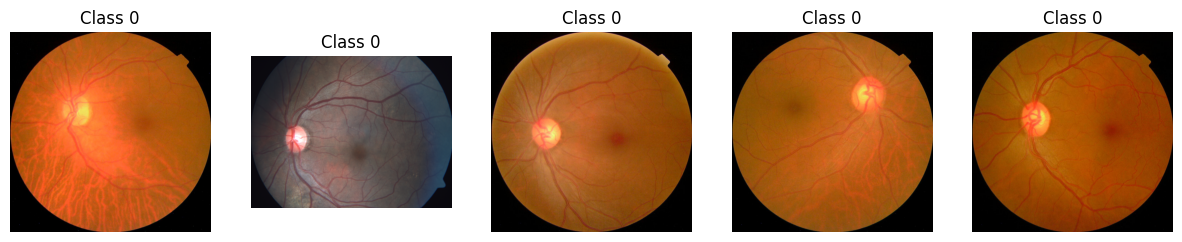

Class 1: 370 samples


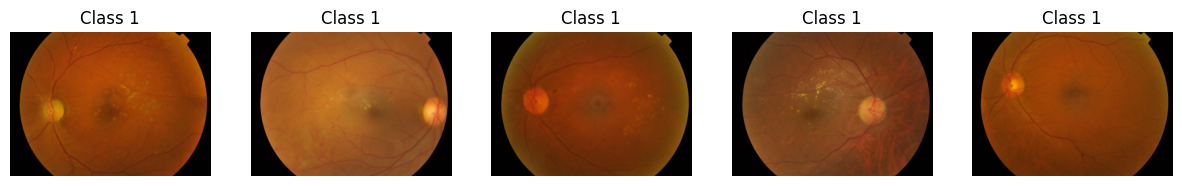

Class 2: 999 samples


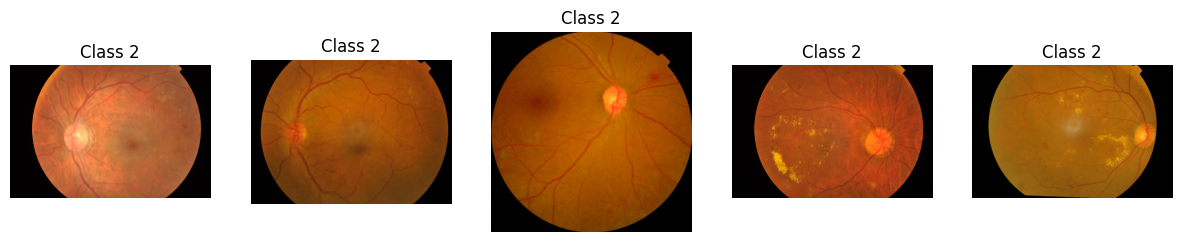

Class 3: 193 samples


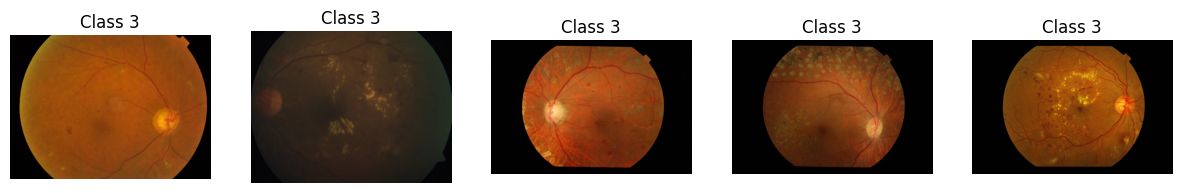

Class 4: 295 samples


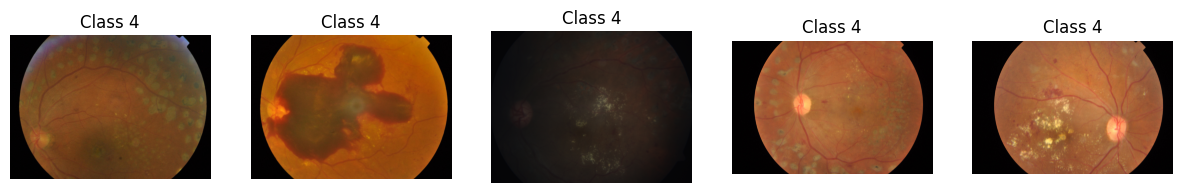

In [7]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Visualize sample images for each class
def visualize_samples(folder_path, csv_path, num_samples=5):
    import pandas as pd
    data = pd.read_csv(csv_path)
    diagnosis_groups = data.groupby('diagnosis')

    for diagnosis, group in diagnosis_groups:
        print(f"Class {diagnosis}: {len(group)} samples")
        sample_ids = group['id_code'].sample(num_samples, random_state=42).values
        plt.figure(figsize=(15, 5))
        for i, sample_id in enumerate(sample_ids):
            file_path = os.path.join(folder_path, f"{sample_id}.png")
            if os.path.exists(file_path):
                img = Image.open(file_path)
                plt.subplot(1, num_samples, i + 1)
                plt.imshow(img)
                plt.title(f"Class {diagnosis}")
                plt.axis('off')
        plt.show()

visualize_samples(train_folder, train_csv)


# Visualization 2: Class Distribution in Training Data



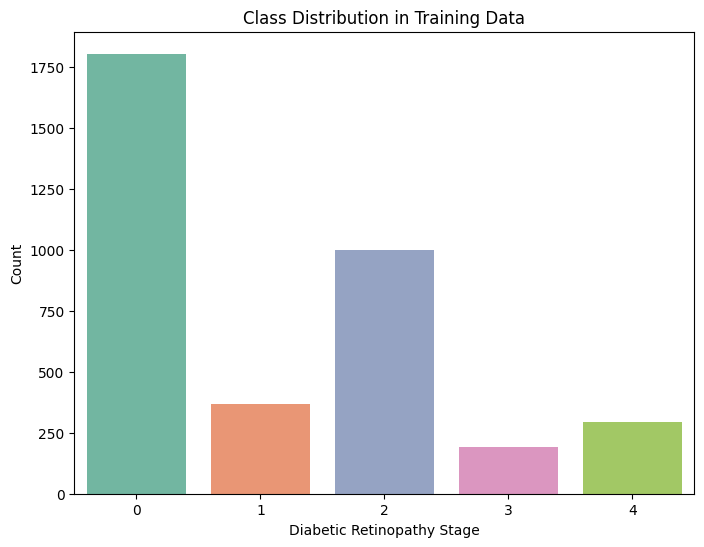

In [8]:
# Load training CSV
data = pd.read_csv(train_csv)

plt.figure(figsize=(8, 6))
sns.countplot(x='diagnosis', hue='diagnosis', data=data, palette='Set2', legend=False)
plt.title("Class Distribution in Training Data")
plt.xlabel("Diabetic Retinopathy Stage")
plt.ylabel("Count")
plt.show()

# Visualization 3: Image Resolution Distribution



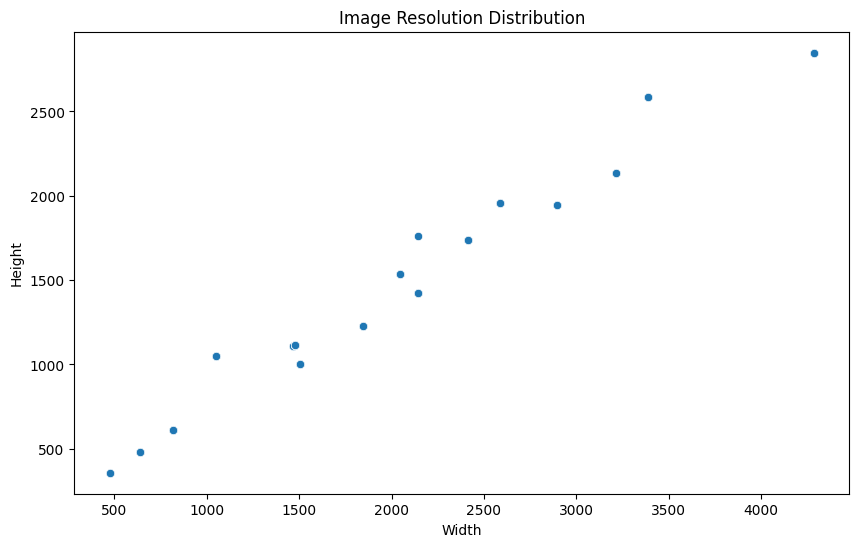

Image Resolution Summary:
             Width       Height
count  3662.000000  3662.000000
mean   2015.176679  1526.830147
std     884.301940   542.663120
min     474.000000   358.000000
25%    1050.000000  1050.000000
50%    2144.000000  1536.000000
75%    2588.000000  1958.000000
max    4288.000000  2848.000000


In [9]:
def image_statistics(folder_path):
    from PIL import Image
    resolutions = []

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            try:
                image_path = os.path.join(root, file)
                with Image.open(image_path) as img:
                    resolutions.append(img.size)
            except Exception as e:
                print(f"Error processing file {file}: {e}")

    return resolutions

# Analyze training images
resolutions = image_statistics(train_folder)
resolution_df = pd.DataFrame(resolutions, columns=['Width', 'Height'])

# Plot resolution distribution
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Width', y='Height', data=resolution_df)
plt.title("Image Resolution Distribution")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

# Summary statistics of resolutions
print("Image Resolution Summary:")
print(resolution_df.describe())

# Visualization 4: Displaying grayscale images by diagnosis



Displaying grayscale images by diagnosis (256x256)...


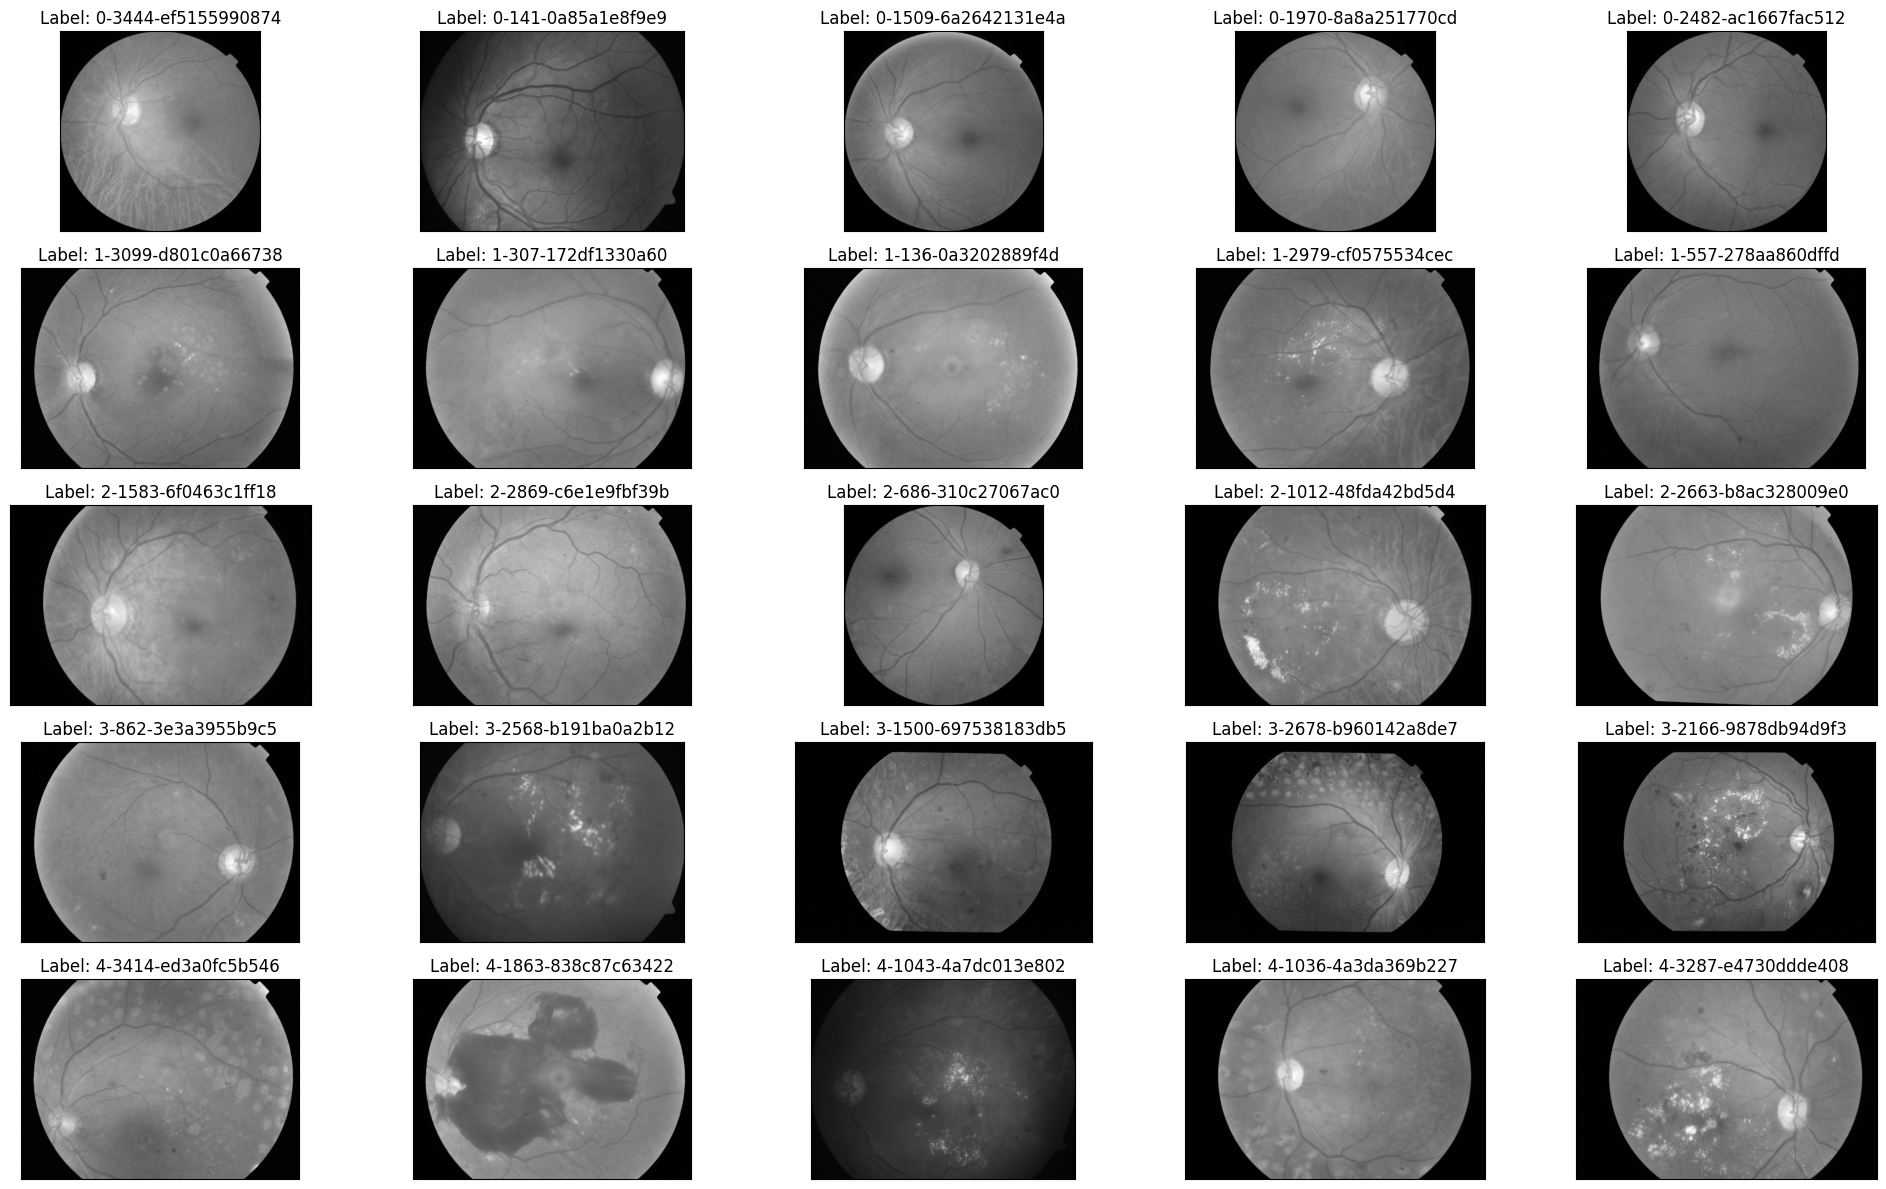

In [10]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt


train_csv_path = r"/content/drive/MyDrive/dataset/train.csv"
train_images_path = r"/content/drive/MyDrive/dataset/train_images"

train = pd.read_csv(train_csv_path)

def display_images_by_severity(df, images_path, grayscale=False):
    """
    Display images grouped by diagnosis (severity) in a grid.
    Args:
        df (pd.DataFrame): DataFrame containing image metadata.
        images_path (str): Path to the folder containing images.
        grayscale (bool): If True, display images in grayscale. Default is False (color).
    """
    fig = plt.figure(figsize=(20, 12))
    for class_id in sorted(df['diagnosis'].unique()):
        for i, (idx, row) in enumerate(df.loc[df['diagnosis'] == class_id].sample(5, random_state=42).iterrows()):
            ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
            path = os.path.join(images_path, f"{row['id_code']}.png")
            image = cv2.imread(path)
            if image is not None:
                if grayscale:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    ax.imshow(image, cmap='gray')
                else:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib
                    ax.imshow(image)
                ax.set_title(f'Label: {class_id}-{idx}-{row["id_code"]}')
            else:
                ax.axis('off')
                ax.set_title(f'Missing Image')
    plt.tight_layout()
    plt.show()
# Display grayscale images by diagnosis
print("Displaying grayscale images by diagnosis (256x256)...")
display_images_by_severity(train, train_images_path, grayscale=True)


# Data Preprocessing

Loading preprocessed data...
Data loaded successfully.


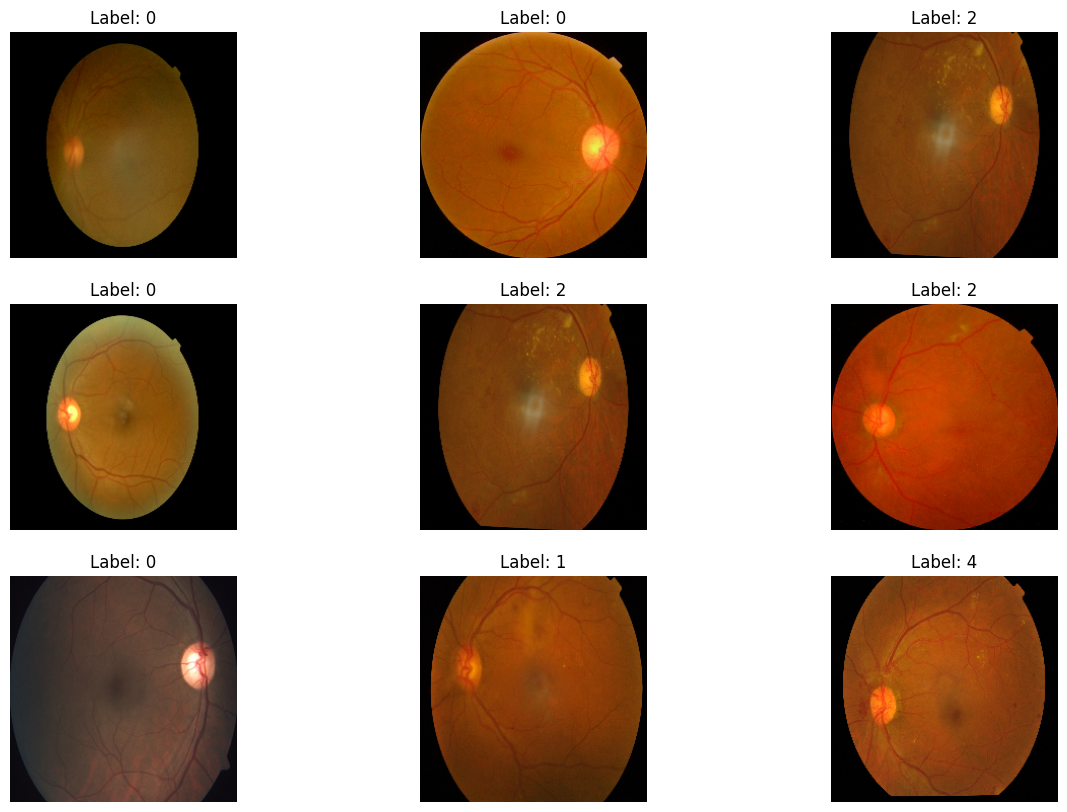

In [14]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter

save_paths = {
    "xTrain": "/content/drive/MyDrive/dataset/xTrain.npy",
    "yTrain": "/content/drive/MyDrive/dataset/yTrain.npy",
    "xVal": "/content/drive/MyDrive/dataset/xVal.npy",
    "yVal": "/content/drive/MyDrive/dataset/yVal.npy",
    "xTest": "/content/drive/MyDrive/dataset/xTest.npy",
    "yTest": "/content/drive/MyDrive/dataset/yTest.npy"
}

# Check if all .npy files exist
if all(os.path.exists(path) for path in save_paths.values()):
    print("Loading preprocessed data...")
    xTrain = np.load(save_paths["xTrain"])
    yTrain = np.load(save_paths["yTrain"])
    xVal = np.load(save_paths["xVal"])
    yVal = np.load(save_paths["yVal"])
    xTest = np.load(save_paths["xTest"])
    yTest = np.load(save_paths["yTest"])
    print("Data loaded successfully.")
else:
    print("Preprocessed data not found. Processing images...")

    train_image = []
    train_label = []

    def label_img(label):
        encoding = np.zeros(5)
        encoding[label] = 1
        return encoding

    for i, j in train.values:
        path = f"/content/drive/MyDrive/dataset/train_images/{i}.png"
        try:
            image = cv2.imread(path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (224, 224))
                train_image.append(np.array(image) / 255)
                train_label.append(label_img(j))
            else:
                print(f"Warning: Image {i}.png not found or corrupted.")
        except Exception as e:
            print(f"Error processing image {i}.png: {e}")

    print("Class distribution:", Counter(np.argmax(train_label, axis=1)))

    # Split dataset into training, validation, and test sets
    xTrain, xTest, yTrain, yTest = train_test_split(train_image, train_label, test_size=0.25, random_state=42)
    xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, test_size=0.15, random_state=42)

    # Convert lists to numpy arrays
    xTrain = np.array(xTrain)
    xTest = np.array(xTest)
    xVal = np.array(xVal)
    yTrain = np.array(yTrain)
    yTest = np.array(yTest)
    yVal = np.array(yVal)

    # Save preprocessed data
    for key, path in save_paths.items():
        np.save(path, locals()[key])
        print(f"Saved {key} to {path}")

# Visualize sample images from the training set
plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(xTrain[i])
    plt.title(f"Label: {np.argmax(yTrain[i])}")
    plt.axis('off')
plt.show()


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Input(shape=(224, 224, 3)),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 111,301 (434.77 KB)

 Trainable params: 110,853 (433.02 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.4879 - loss: 1.3000 - val_accuracy: 0.2694 - val_loss: 1.9896
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.6537 - loss: 0.9811 - val_accuracy: 0.2670 - val_loss: 2.2267
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.7095 - loss: 0.8460 - val_accuracy: 0.2646 - val_loss: 2.3492
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.7028 - loss: 0.8141 - val_accuracy: 0.2694 - val_loss: 2.5130
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.7231 - loss: 0.8082 - val_accuracy: 0.2694 - val_loss: 2.2371
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.7333 - loss: 0.7791 - val_accuracy: 0.2694 - val_loss: 1.9254
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.7216 - loss: 0.7991 - val_accuracy: 0.4393 - val_loss: 1.3203
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.7297 - loss: 0.7629 - val_accuracy: 0.3883 - v

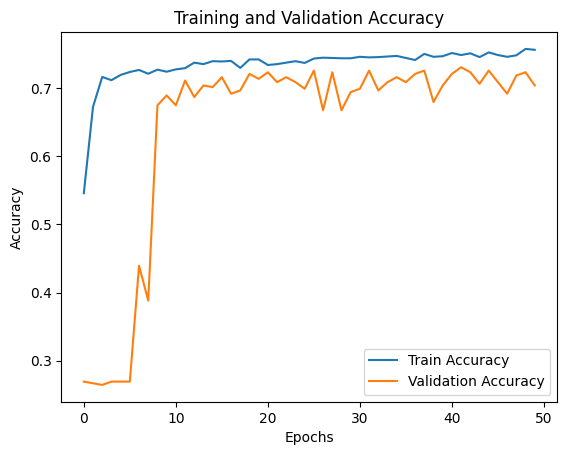

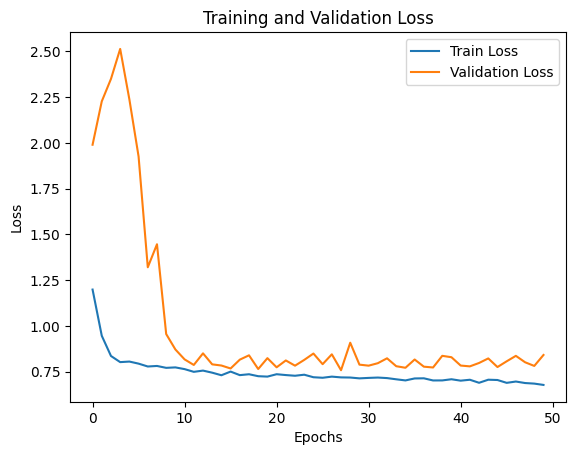

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

history = model.fit(
    xTrain, yTrain,
    validation_data=(xVal, yVal),
    epochs=50,
    batch_size=32,
    verbose=1
)

test_loss, test_accuracy = model.evaluate(xTest, yTest)
print(f"Test Accuracy: {test_accuracy}")

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [15]:
model.save("/content/drive/MyDrive/dataset/my_model.keras")

In [16]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/dataset/my_model.keras")

In [18]:
from sklearn.metrics import classification_report

yPred = model.predict(xTest)
yPred_classes = np.argmax(yPred, axis=1)
yTrue = np.argmax(yTest, axis=1)

print(classification_report(yTrue, yPred_classes, zero_division=1))


29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 290ms/step
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       450
           1       0.29      0.19      0.23        81
           2       0.55      0.80      0.65       257
           3       0.44      0.09      0.15        44
           4       1.00      0.00      0.00        84

    accuracy                           0.72       916
   macro avg       0.64      0.41      0.39       916
weighted avg       0.74      0.72      0.67       916



In [19]:
from collections import Counter
print("Training set distribution:", Counter(np.argmax(yTrain, axis=1)))
print("Validation set distribution:", Counter(np.argmax(yVal, axis=1)))
print("Test set distribution:", Counter(yTrue))

Training set distribution: Counter({0: 1165, 2: 631, 1: 236, 4: 168, 3: 134})
Validation set distribution: Counter({0: 190, 2: 111, 1: 53, 4: 43, 3: 15})
Test set distribution: Counter({0: 450, 2: 257, 4: 84, 1: 81, 3: 44})
